In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
%cd drive/'My Drive'/'Colab Notebooks'/Rock-Paper-Scissor

/content/drive/My Drive/Colab Notebooks/Rock-Paper-Scissor


In [56]:
#!unzip rock-paper-scissor.zip

In [271]:
!ls

Dataset			weights.15-0.57.hdf5	weights_c.03-0.38.hdf5
final_model1.h5		weights_b.06-0.62.hdf5	weights_c.03-0.67.hdf5
final_model2.h5		weights_b.08-0.46.hdf5	weights_c.03-0.76.hdf5
final_model4.h5		weights_c.01-0.40.hdf5	weights_c.03-0.88.hdf5
final_model5.h5		weights_c.01-0.91.hdf5	weights_c.04-0.61.hdf5
final_tflite		weights_c.01-0.97.hdf5	weights_c.05-0.63.hdf5
final_weights1.h5	weights_c.01-1.07.hdf5	weights_c.05-0.66.hdf5
final_weights2.h5	weights_c.01-1.11.hdf5	weights_c.06-0.65.hdf5
final_weights4.h5	weights_c.01-1.53.hdf5	weights_c.06-0.66.hdf5
final_weights5.h5	weights_c.01-1.55.hdf5	weights_c.08-0.59.hdf5
RockPaperScissor.ipynb	weights_c.02-0.73.hdf5	weights_c.08-0.63.hdf5
rock-paper-scissor.zip	weights_c.02-0.76.hdf5	weights_c.09-0.26.hdf5
weights.01-0.95.hdf5	weights_c.02-0.82.hdf5	weights_c.11-0.57.hdf5
weights.02-0.85.hdf5	weights_c.02-0.94.hdf5	weights_new.02-0.58.hdf5
weights.03-0.87.hdf5	weights_c.02-1.29.hdf5	weights_new.04-0.57.hdf5
weights.04-0.63.hdf5	weights_c.03-0

In [ ]:
!pip install scrapy

In [270]:
import keras as k
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D , LeakyReLU
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.optimizers import RMSprop,SGD,Adam
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
import keras.backend as K
from tensorflow.keras.models import load_model
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scrapy
import seaborn as sns
import cv2
%matplotlib inline

In [6]:
img_height = 100
img_width = 100
batch_size = 16

In [373]:
data_image_gen = k.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.5, 1.5],
    channel_shift_range=0.05,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2
)

train_data_generator = data_image_gen.flow_from_directory(
    'Dataset',
    subset='training',
    target_size=(img_height, img_width),
    color_mode="rgb", #grayscale
    shuffle=True,
    batch_size=batch_size,
    class_mode='categorical',
    seed=42
)

validation_data_generator = data_image_gen.flow_from_directory(
    'Dataset',
    subset='validation',
    target_size=(img_height, img_width),
    color_mode="rgb", #grayscale
    shuffle=True,
    batch_size=batch_size,
    class_mode='categorical',
    seed=42
)

Found 1751 images belonging to 3 classes.
Found 437 images belonging to 3 classes.


In [111]:
unique, count = np.unique(train_data_generator.classes,return_counts=True)
print('train_dataset : samples per class')
print(dict(zip(train_data_generator.class_indices,count)))

unique, count = np.unique(validation_data_generator.classes,return_counts=True)
print('\nvalidation_dataset : samples per class')
dict(zip(validation_data_generator.class_indices,count))

train_dataset : samples per class
{'paper': 641, 'rock': 654, 'scissors': 675}

validation_dataset : samples per class


{'paper': 71, 'rock': 72, 'scissors': 75}

In [47]:
def showImges(img_arr):
  fig, axes = plt.subplots(nrows=2,ncols=3,figsize=(5,5))
  axes=axes.flatten()
  for img, ax in zip( img_arr, axes):
          ax.imshow(img)
          ax.axis('off')
  plt.tight_layout()
  plt.show()

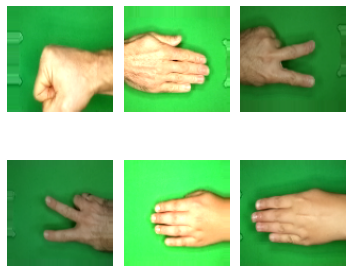

In [51]:
sample_training_imgs,_=next(train_data_generator)
showImges(sample_training_imgs[:6])

In [439]:
#custom model
x_input=Input((img_width,img_height,3))

x = Conv2D(filters=32,kernel_size=(3,3),strides=(1,1),padding='same',kernel_regularizer=k.regularizers.l2(0.0005),name='conv2d_1')(x_input)
x = BatchNormalization(epsilon=0.001, name='bnorm_1',axis=3)(x)
x = Activation('relu',name='acti_conv2d_1')(x)


x = MaxPooling2D((2, 2), name='max_pool')(x)

x = Conv2D(filters=64,kernel_size=(3,3),strides=(1,1),padding='valid',kernel_regularizer=k.regularizers.l2(1e-4),name='conv2d_2')(x)
x = BatchNormalization(name='bnorm_2',axis=3)(x)
x = LeakyReLU(alpha=0.3,name='leaky_2')(x)

x = Conv2D(filters=64,kernel_size=(3,3),strides=(1,1),padding='same',kernel_regularizer=k.regularizers.l2(1e-4),name='conv2d_3')(x)
x = BatchNormalization(name='bnorm_3',axis=3)(x)
x = LeakyReLU(alpha=0.3,name='leaky_3')(x)

x = AveragePooling2D((2, 2), name='avg_pool')(x)

x = Flatten()(x)

x = Dense(256,kernel_regularizer=k.regularizers.l2(1e-4), name='fc_1')(x)
x = LeakyReLU(alpha=0.3)(x)
x = Dense(125, kernel_regularizer=k.regularizers.l2(1e-4), name='fc_2')(x)
x = LeakyReLU(alpha=0.3)(x)
x = Dense(3, kernel_regularizer=k.regularizers.l2(1e-4), name='fc_3')(x)
x = Activation('softmax',name='softmax_activation')(x)
model5 = Model(inputs = x_input, outputs = x, name='CustomModel')

In [100]:
model2_1.summary()

Model: "CustomModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 100, 100, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 32)      896       
_________________________________________________________________
bnorm_1 (BatchNormalization) (None, 100, 100, 32)      128       
_________________________________________________________________
acti_conv2d_1 (Activation)   (None, 100, 100, 32)      0         
_________________________________________________________________
max_pool (MaxPooling2D)      (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 64)        18496     
_________________________________________________________________
bnorm_2 (BatchNormalization) (None, 48, 48, 64)        

In [440]:
model5.compile(loss='categorical_crossentropy',metrics=['accuracy'],
              optimizer=SGD(learning_rate=0.02,momentum=0.9))

In [255]:
model4.compile(loss='categorical_crossentropy',metrics=['accuracy'],
              optimizer=SGD(learning_rate=0.01,momentum=0.9))

In [199]:
model2_5.compile(loss='categorical_crossentropy',metrics=['accuracy'],
              optimizer=SGD(learning_rate=0.02,momentum=0.9))

In [175]:
model2_4.compile(loss='categorical_crossentropy',metrics=['accuracy'],
              optimizer=SGD(learning_rate=0.02,momentum=0.9))

In [160]:
model2_3.compile(loss='categorical_crossentropy',metrics=['accuracy'],
              optimizer=SGD(learning_rate=0.02,momentum=0.9))

In [113]:
model2_2.compile(loss='categorical_crossentropy',metrics=['accuracy'],
              optimizer=SGD(learning_rate=0.02,momentum=0.9))

In [10]:
model2_1.compile(loss='categorical_crossentropy',metrics=['accuracy'],
              optimizer=RMSprop())

model3.compile(loss='categorical_crossentropy',metrics=['accuracy'],
              optimizer=RMSprop())

model2.compile(loss='categorical_crossentropy',metrics=['accuracy'],
              optimizer=RMSprop())

model.compile(loss='categorical_crossentropy',metrics=['accuracy'],
              optimizer=Adam(learning_rate=0.01))

In [118]:
model2_2.load_weights('weights.03-0.87.hdf5')

In [473]:
history5=model5.fit(
    train_data_generator,
    epochs=20,
    verbose=1,
    validation_data=validation_data_generator,
    shuffle=True,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=3,restore_best_weights=True, min_delta=0.1),
        ModelCheckpoint('weights.{epoch:02d}-{val_loss:.2f}.hdf5',monitor='val_loss',save_best_only=True,mode='auto')
    ]
)

Epoch 1/20
110/110 [==============================] - 18s 166ms/step - loss: 0.6121 - accuracy: 0.8264 - val_loss: 1.1275 - val_accuracy: 0.8719
Epoch 2/20
110/110 [==============================] - 17s 154ms/step - loss: 0.5326 - accuracy: 0.8498 - val_loss: 0.8057 - val_accuracy: 0.8375
Epoch 3/20
110/110 [==============================] - 17s 156ms/step - loss: 0.5434 - accuracy: 0.8521 - val_loss: 0.5105 - val_accuracy: 0.8833
Epoch 4/20
110/110 [==============================] - 17s 155ms/step - loss: 0.4705 - accuracy: 0.8818 - val_loss: 0.4258 - val_accuracy: 0.8947
Epoch 5/20
110/110 [==============================] - 17s 155ms/step - loss: 0.5335 - accuracy: 0.8578 - val_loss: 0.8034 - val_accuracy: 0.7918
Epoch 6/20
110/110 [==============================] - 16s 150ms/step - loss: 0.4646 - accuracy: 0.8772 - val_loss: 0.2186 - val_accuracy: 0.9153
Epoch 7/20
110/110 [==============================] - 17s 158ms/step - loss: 0.4960 - accuracy: 0.8772 - val_loss: 0.8262 - val_ac

In [256]:
history4=model4.fit(
    train_data_generator,
    epochs=20,
    verbose=1,
    validation_data=validation_data_generator,
    shuffle=True,
    callbacks=[
               EarlyStopping(monitor='val_loss', patience=3,restore_best_weights=True),
               ModelCheckpoint('weights_c.{epoch:02d}-{val_loss:.2f}.hdf5',monitor='val_loss',save_best_only=True,mode='auto')
    ]
)

Epoch 1/20
110/110 [==============================] - 17s 156ms/step - loss: 0.8649 - accuracy: 0.7019 - val_loss: 1.5455 - val_accuracy: 0.3318
Epoch 2/20
110/110 [==============================] - 16s 143ms/step - loss: 0.7095 - accuracy: 0.8658 - val_loss: 1.2949 - val_accuracy: 0.3707
Epoch 3/20
110/110 [==============================] - 16s 144ms/step - loss: 0.6483 - accuracy: 0.9246 - val_loss: 0.7611 - val_accuracy: 0.5652
Epoch 4/20
110/110 [==============================] - 16s 144ms/step - loss: 0.6346 - accuracy: 0.9400 - val_loss: 1.2840 - val_accuracy: 0.5217
Epoch 5/20
110/110 [==============================] - 17s 150ms/step - loss: 0.6258 - accuracy: 0.9429 - val_loss: 1.2695 - val_accuracy: 0.6613
Epoch 6/20
110/110 [==============================] - 16s 142ms/step - loss: 0.6167 - accuracy: 0.9503 - val_loss: 0.6603 - val_accuracy: 0.8421
Epoch 7/20
110/110 [==============================] - 16s 145ms/step - loss: 0.6094 - accuracy: 0.9572 - val_loss: 0.7430 - val_ac

In [200]:
history2_5=model2_5.fit(
    train_data_generator,
    epochs=20,
    verbose=1,
    validation_data=validation_data_generator,
    shuffle=True,
    callbacks=[
               EarlyStopping(monitor='val_loss', patience=3,restore_best_weights=True),
               ModelCheckpoint('weights_c.{epoch:02d}-{val_loss:.2f}.hdf5',monitor='val_loss',save_best_only=True,mode='auto')
    ]
)

Epoch 1/20
110/110 [==============================] - 18s 168ms/step - loss: 0.7990 - accuracy: 0.6528 - val_loss: 1.3078 - val_accuracy: 0.5423
Epoch 2/20
110/110 [==============================] - 16s 146ms/step - loss: 0.5032 - accuracy: 0.8618 - val_loss: 1.8351 - val_accuracy: 0.5950
Epoch 3/20
110/110 [==============================] - 16s 142ms/step - loss: 0.3884 - accuracy: 0.9372 - val_loss: 0.8778 - val_accuracy: 0.8604
Epoch 4/20
110/110 [==============================] - 16s 145ms/step - loss: 0.4103 - accuracy: 0.9218 - val_loss: 1.1025 - val_accuracy: 0.5973
Epoch 5/20
110/110 [==============================] - 15s 140ms/step - loss: 0.3384 - accuracy: 0.9572 - val_loss: 0.6641 - val_accuracy: 0.9130
Epoch 6/20
110/110 [==============================] - 16s 144ms/step - loss: 0.3351 - accuracy: 0.9589 - val_loss: 0.6541 - val_accuracy: 0.8032
Epoch 7/20
110/110 [==============================] - 16s 143ms/step - loss: 0.3420 - accuracy: 0.9509 - val_loss: 0.6599 - val_ac

In [176]:
history2_4=model2_4.fit(
    train_data_generator,
    epochs=20,
    verbose=1,
    validation_data=validation_data_generator,
    shuffle=True,
    callbacks=[
               EarlyStopping(monitor='val_loss', patience=3),
               ModelCheckpoint('weights_b.{epoch:02d}-{val_loss:.2f}.hdf5',monitor='val_loss',save_best_only=True,mode='auto')
    ]
)

Epoch 1/20
124/124 [==============================] - 18s 144ms/step - loss: 0.9810 - accuracy: 0.3437 - val_loss: 1.1708 - val_accuracy: 0.3532
Epoch 2/20
124/124 [==============================] - 17s 135ms/step - loss: 0.6318 - accuracy: 0.7665 - val_loss: 1.5907 - val_accuracy: 0.3211
Epoch 3/20
124/124 [==============================] - 16s 130ms/step - loss: 0.5152 - accuracy: 0.8492 - val_loss: 1.1923 - val_accuracy: 0.4908
Epoch 4/20
124/124 [==============================] - 16s 130ms/step - loss: 0.3942 - accuracy: 0.9310 - val_loss: 1.0523 - val_accuracy: 0.3899
Epoch 5/20
124/124 [==============================] - 16s 132ms/step - loss: 0.3581 - accuracy: 0.9457 - val_loss: 1.2958 - val_accuracy: 0.3303
Epoch 6/20
124/124 [==============================] - 16s 130ms/step - loss: 0.3288 - accuracy: 0.9624 - val_loss: 0.6178 - val_accuracy: 0.8349
Epoch 7/20
124/124 [==============================] - 16s 128ms/step - loss: 0.3242 - accuracy: 0.9711 - val_loss: 1.6024 - val_ac

In [161]:
history2_3=model2_3.fit(
    train_data_generator,
    epochs=20,
    verbose=1,
    validation_data=validation_data_generator,
    shuffle=True,
    callbacks=[
               EarlyStopping(monitor='val_loss', patience=3),
               ModelCheckpoint('weights.{epoch:02d}-{val_loss:.2f}.hdf5',monitor='val_loss',save_best_only=True,mode='auto')
    ]
)

Epoch 1/20
124/124 [==============================] - 17s 141ms/step - loss: 0.6977 - accuracy: 0.7244 - val_loss: 1.4402 - val_accuracy: 0.3303
Epoch 2/20
124/124 [==============================] - 18s 144ms/step - loss: 0.4374 - accuracy: 0.9051 - val_loss: 0.8476 - val_accuracy: 0.4587
Epoch 3/20
124/124 [==============================] - 17s 135ms/step - loss: 0.3912 - accuracy: 0.9264 - val_loss: 1.3736 - val_accuracy: 0.4083
Epoch 4/20
124/124 [==============================] - 16s 132ms/step - loss: 0.3960 - accuracy: 0.9234 - val_loss: 1.1563 - val_accuracy: 0.6193
Epoch 5/20
124/124 [==============================] - 16s 132ms/step - loss: 0.3546 - accuracy: 0.9503 - val_loss: 0.8646 - val_accuracy: 0.4587


In [114]:
history2_2=model2_2.fit(
    train_data_generator,
    epochs=20,
    verbose=1,
    validation_data=validation_data_generator,
    shuffle=True,
    callbacks=[
               EarlyStopping(monitor='val_loss', patience=3),
               ModelCheckpoint('weights.{epoch:02d}-{val_loss:.2f}.hdf5',monitor='val_loss',save_best_only=True,mode='auto')
    ]
)

Epoch 1/20
124/124 [==============================] - 18s 142ms/step - loss: 0.9471 - accuracy: 0.6685 - val_loss: 1.0459 - val_accuracy: 0.3303
Epoch 2/20
124/124 [==============================] - 17s 134ms/step - loss: 0.7097 - accuracy: 0.8888 - val_loss: 0.9031 - val_accuracy: 0.3303
Epoch 3/20
124/124 [==============================] - 17s 134ms/step - loss: 0.6389 - accuracy: 0.9421 - val_loss: 0.8657 - val_accuracy: 0.5413
Epoch 4/20
124/124 [==============================] - 17s 136ms/step - loss: 0.6471 - accuracy: 0.9335 - val_loss: 0.8664 - val_accuracy: 0.4358
Epoch 5/20
124/124 [==============================] - 16s 133ms/step - loss: 0.6162 - accuracy: 0.9563 - val_loss: 0.9000 - val_accuracy: 0.6422
Epoch 6/20
124/124 [==============================] - 16s 133ms/step - loss: 0.6147 - accuracy: 0.9584 - val_loss: 1.0231 - val_accuracy: 0.3394


In [117]:
history2_2_2=model2_2.fit(
    train_data_generator,
    epochs=20,
    verbose=1,
    validation_data=validation_data_generator,
    shuffle=True,
    callbacks=[
               ModelCheckpoint('weights.{epoch:02d}-{val_loss:.2f}.hdf5',monitor='val_loss',save_best_only=True,mode='auto')
    ]
)

Epoch 1/20
124/124 [==============================] - 17s 137ms/step - loss: 0.6377 - accuracy: 0.9401 - val_loss: 0.9032 - val_accuracy: 0.5505
Epoch 2/20
124/124 [==============================] - 17s 136ms/step - loss: 0.6339 - accuracy: 0.9391 - val_loss: 1.1303 - val_accuracy: 0.5413
Epoch 3/20
124/124 [==============================] - 16s 131ms/step - loss: 0.6224 - accuracy: 0.9467 - val_loss: 0.6705 - val_accuracy: 0.8257
Epoch 4/20
124/124 [==============================] - 17s 135ms/step - loss: 0.6116 - accuracy: 0.9589 - val_loss: 0.6328 - val_accuracy: 0.9266
Epoch 5/20
124/124 [==============================] - 16s 133ms/step - loss: 0.6043 - accuracy: 0.9685 - val_loss: 1.0453 - val_accuracy: 0.3486
Epoch 6/20
124/124 [==============================] - 16s 132ms/step - loss: 0.6037 - accuracy: 0.9701 - val_loss: 0.6505 - val_accuracy: 0.9128
Epoch 7/20
124/124 [==============================] - 16s 133ms/step - loss: 0.6032 - accuracy: 0.9690 - val_loss: 0.6687 - val_ac

In [120]:
model2_2.load_weights('weights.15-0.57.hdf5')

In [121]:
history2_2_3=model2_2.fit(
    train_data_generator,
    epochs=20,
    verbose=1,
    validation_data=validation_data_generator,
    shuffle=True,
    callbacks=[
               EarlyStopping(monitor='val_loss', patience=3),
               ModelCheckpoint('weights_new.{epoch:02d}-{val_loss:.2f}.hdf5',monitor='val_loss',save_best_only=True,mode='auto')
    ]
)

Epoch 1/20
124/124 [==============================] - 17s 137ms/step - loss: 0.5903 - accuracy: 0.9792 - val_loss: 0.5898 - val_accuracy: 0.9220
Epoch 2/20
124/124 [==============================] - 17s 136ms/step - loss: 0.5910 - accuracy: 0.9807 - val_loss: 0.5765 - val_accuracy: 0.9725
Epoch 3/20
124/124 [==============================] - 17s 137ms/step - loss: 0.5862 - accuracy: 0.9822 - val_loss: 0.9983 - val_accuracy: 0.7064
Epoch 4/20
124/124 [==============================] - 17s 134ms/step - loss: 0.5938 - accuracy: 0.9746 - val_loss: 0.5679 - val_accuracy: 0.9495
Epoch 5/20
124/124 [==============================] - 17s 138ms/step - loss: 0.5915 - accuracy: 0.9756 - val_loss: 0.9124 - val_accuracy: 0.6835
Epoch 6/20
124/124 [==============================] - 16s 133ms/step - loss: 0.5855 - accuracy: 0.9822 - val_loss: 0.7907 - val_accuracy: 0.9312
Epoch 7/20
124/124 [==============================] - 17s 134ms/step - loss: 0.5921 - accuracy: 0.9782 - val_loss: 0.6938 - val_ac

In [486]:
model5.save('final_custom_model7.h5')
model5.save_weights('final_custom_weights7.h5')

In [ ]:
history=model.fit_generator(
    train_data_generator,
    epochs=5,
    verbose=1,
    validation_data=validation_data_generator,
    shuffle=True,
    callbacks=[
               EarlyStopping(monitor='val_loss', patience=3),
               ModelCheckpoint('weights.{epoch:02d}-{val_loss:.2f}.hdf5',monitor='val_loss',save_best_only=True,mode='auto')
    ]
)

In [27]:
history3=model3.fit_generator(
    train_data_generator,
    epochs=20,
    verbose=1,
    validation_data=validation_data_generator,
    shuffle=True,
    callbacks=[
               EarlyStopping(monitor='val_loss', patience=3),
               ModelCheckpoint('weights.{epoch:02d}-{val_loss:.2f}.hdf5',monitor='val_loss',save_best_only=True,mode='auto')
    ]
)

Epoch 1/5
110/110 [==============================] - 18s 166ms/step - loss: 1.1214 - accuracy: 0.3244 - val_loss: 1.1177 - val_accuracy: 0.3249
Epoch 2/5
110/110 [==============================] - 17s 152ms/step - loss: 1.1104 - accuracy: 0.3312 - val_loss: 1.1102 - val_accuracy: 0.3249
Epoch 3/5
110/110 [==============================] - 17s 155ms/step - loss: 1.1077 - accuracy: 0.3221 - val_loss: 1.1042 - val_accuracy: 0.3249
Epoch 4/5
110/110 [==============================] - 17s 152ms/step - loss: 1.1012 - accuracy: 0.3255 - val_loss: 1.0993 - val_accuracy: 0.3249
Epoch 5/5
110/110 [==============================] - 17s 152ms/step - loss: 1.0978 - accuracy: 0.3255 - val_loss: 1.1270 - val_accuracy: 0.3249


In [42]:
history2_1=model2_1.fit_generator(
    train_data_generator,
    epochs=20,
    verbose=1,
    validation_data=validation_data_generator,
    shuffle=True,
    callbacks=[
               EarlyStopping(monitor='val_loss', patience=3),
               ModelCheckpoint('weights.{epoch:02d}-{val_loss:.2f}.hdf5',monitor='val_loss',save_best_only=True,mode='auto')
    ]
)

Epoch 1/20
110/110 [==============================] - 19s 175ms/step - loss: 1.1489 - accuracy: 0.3312 - val_loss: 1.1323 - val_accuracy: 0.3318
Epoch 2/20
110/110 [==============================] - 17s 158ms/step - loss: 1.1014 - accuracy: 0.3221 - val_loss: 1.0989 - val_accuracy: 0.3249
Epoch 3/20
110/110 [==============================] - 17s 157ms/step - loss: 1.0990 - accuracy: 0.3238 - val_loss: 1.0987 - val_accuracy: 0.3249
Epoch 4/20
110/110 [==============================] - 17s 158ms/step - loss: 1.0987 - accuracy: 0.3255 - val_loss: 1.0986 - val_accuracy: 0.3249
Epoch 5/20
110/110 [==============================] - 17s 157ms/step - loss: 1.0986 - accuracy: 0.3255 - val_loss: 1.0986 - val_accuracy: 0.3249
Epoch 6/20
110/110 [==============================] - 18s 160ms/step - loss: 1.0986 - accuracy: 0.3255 - val_loss: 1.0986 - val_accuracy: 0.3249
Epoch 7/20
110/110 [==============================] - 18s 160ms/step - loss: 1.0986 - accuracy: 0.3255 - val_loss: 1.0986 - val_ac

KeyboardInterrupt: ignored

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


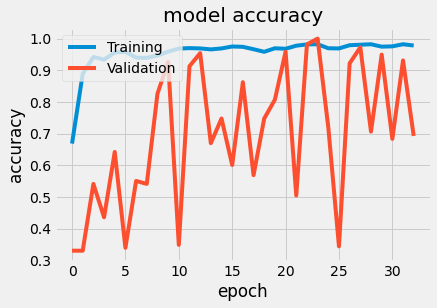

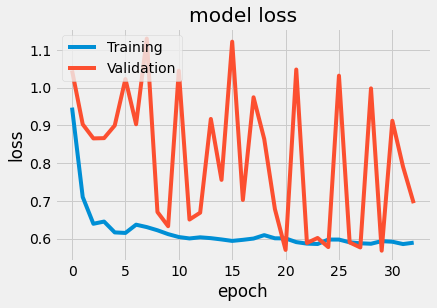

In [341]:
print(complete_train_history.keys())

plt.style.use('fivethirtyeight')
# summarize history for accuracy
plt.plot(complete_train_history['accuracy'])
plt.plot(complete_train_history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(complete_train_history['loss'])
plt.plot(complete_train_history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

In [136]:
complete_train_history = {'val_loss':[],'val_accuracy':[],'loss':[],'accuracy':[]}
complete_train_history['val_loss'] = history2_2.history['val_loss'] + history2_2_2.history['val_loss'] + history2_2_3.history['val_loss']
complete_train_history['val_accuracy'] = history2_2.history['val_accuracy'] + history2_2_2.history['val_accuracy'] + history2_2_3.history['val_accuracy']
complete_train_history['loss'] = history2_2.history['loss'] + history2_2_2.history['loss'] + history2_2_3.history['loss']
complete_train_history['accuracy'] = history2_2.history['accuracy'] + history2_2_2.history['accuracy'] + history2_2_3.history['accuracy']


In [ ]:
complete_train_history

In [268]:
inception_base = k.applications.ResNet50(weights='imagenet',input_shape=(100,100,3), include_top=False)

x = inception_base.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)
inception_transfer = Model(inputs=inception_base.input, outputs=predictions)

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [272]:
inception_transfer.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=1e-4,amsgrad=True),
              metrics=['accuracy'])

In [273]:
with tf.device("/device:GPU:0"):
    history_pretrained = inception_transfer.fit(
    train_data_generator,
    epochs = 5, 
    shuffle = True, 
    verbose = 1, 
    callbacks = [EarlyStopping(monitor='val_loss', patience=3),
               ModelCheckpoint('weights.{epoch:02d}-{val_loss:.2f}.hdf5',monitor='val_loss',save_best_only=True,mode='auto')],
    validation_data = validation_data_generator)

Epoch 1/5
110/110 [==============================] - 64s 584ms/step - loss: 0.1115 - accuracy: 0.9595 - val_loss: 5.2455 - val_accuracy: 0.3318
Epoch 2/5
110/110 [==============================] - 44s 396ms/step - loss: 0.0370 - accuracy: 0.9914 - val_loss: 9.9892 - val_accuracy: 0.3318
Epoch 3/5
110/110 [==============================] - 43s 390ms/step - loss: 0.0345 - accuracy: 0.9931 - val_loss: 2.5203 - val_accuracy: 0.4005
Epoch 4/5
110/110 [==============================] - 43s 391ms/step - loss: 0.0421 - accuracy: 0.9891 - val_loss: 3.9079 - val_accuracy: 0.3410
Epoch 5/5
110/110 [==============================] - 43s 390ms/step - loss: 0.0402 - accuracy: 0.9926 - val_loss: 0.9977 - val_accuracy: 0.4828


In [141]:
import os

In [277]:
model2= load_model(filepath="final_model2.h5")
# model2.load_weights('weights_c.08-0.59.hdf5')

In [333]:
x=cv2.imread('Dataset/rock/01dM3ewPIsnBICu1.png')
x=cv2.resize(x,(100,100))
x = x / 255
img_arr=np.array(x)
img = np.array([img_arr])
print(img.shape)
y=model5.predict(img)
print(np.max(y))
print(np.argmax(y,axis=1))
print(os.listdir('Dataset')[np.argmax(y,axis=1)[0]])


(1, 100, 100, 3)
0.99996555
[1]
rock


In [474]:
# after error
x=cv2.imread('Dataset/rock/01dM3ewPIsnBICu1.png')
x=cv2.resize(x,(100,100))
x = x / 255
img_arr=np.array(x)
img = np.array([img_arr])
print(img.shape)
y=model5.predict(img)
print(np.max(y))
print(np.argmax(y,axis=1))
print(os.listdir('Dataset')[np.argmax(y,axis=1)[0]])

(1, 100, 100, 3)
0.9971143
[1]
rock


In [334]:
x=cv2.imread('Dataset/scissors/1VRzspyXpQ6A2rKy.png')
x=cv2.resize(x,(100,100))
x = x / 255
img_arr=np.array(x)
img = np.array([img_arr])
print(img.shape)
y=model5.predict(img)
print(np.max(y))
print(np.argmax(y,axis=1))
print(os.listdir('Dataset')[np.argmax(y,axis=1)[0]])


(1, 100, 100, 3)
0.9999989
[2]
scissors


In [475]:
# after error
x=cv2.imread('Dataset/scissors/1VRzspyXpQ6A2rKy.png')
x=cv2.resize(x,(100,100))
x = x / 255
img_arr=np.array(x)
img = np.array([img_arr])
print(img.shape)
y=model5.predict(img)
print(np.max(y))
print(np.argmax(y,axis=1))
print(os.listdir('Dataset')[np.argmax(y,axis=1)[0]])

(1, 100, 100, 3)
0.92297393
[2]
scissors


In [378]:
all_imgs = []
imgs = os.listdir('Dataset/scissors')
imgs = imgs[10:20]
for img in imgs:
  x = cv2.imread('Dataset/scissors/' + img, 3)
  x=cv2.resize(x,(100,100))
  x = np.array(x) / 255
  all_imgs.append(x)
all_imgs = np.array(all_imgs)


y=model5.predict(x=all_imgs)
for e in y:
  print(np.argmax(e))

2
2
2
2
2
2
2
2
2
2


In [485]:
#try
x=cv2.imread('/content/images (1).jpg')
x=cv2.resize(x,(100,100))
x = x / 255
img_arr=np.array(x)
img = np.array([img_arr])
print(img.shape)
y=model5.predict(img)
print(np.max(y))
print(np.argmax(y,axis=1))
print(os.listdir('Dataset')[np.argmax(y,axis=1)[0]])
y

(1, 100, 100, 3)
0.5202414
[0]
paper


array([[5.2024138e-01, 4.7975859e-01, 1.2077298e-08]], dtype=float32)

In [335]:
x=cv2.imread('Dataset/paper/4484TuJc6AH7pDOG.png')
x=cv2.resize(x,(100,100))
x = x / 255
img_arr=np.array(x)
img = np.array([img_arr])
print(img.shape)
y=model5.predict(img)
print(np.max(y))
print(np.argmax(y,axis=1))
print(os.listdir('Dataset')[np.argmax(y,axis=1)[0]])
y


(1, 100, 100, 3)
0.926993
[0]
paper


array([[0.926993  , 0.00245418, 0.07055277]], dtype=float32)

In [480]:
# after error
x=cv2.imread('Dataset/paper/4484TuJc6AH7pDOG.png')
x=cv2.resize(x,(100,100))
x = x / 255
img_arr=np.array(x)
img = np.array([img_arr])
print(img.shape)
y=model5.predict(img)
print(np.max(y))
print(np.argmax(y,axis=1))
print(os.listdir('Dataset')[np.argmax(y,axis=1)[0]])
y

(1, 100, 100, 3)
0.9464415
[0]
paper


array([[0.9464415 , 0.0359696 , 0.01758886]], dtype=float32)

In [345]:
all_imgs = []
imgs = os.listdir('Dataset/paper')
imgs = imgs[:10]
for img in imgs:
  x = cv2.imread('Dataset/paper/' + img, 3)
  x=cv2.resize(x,(100,100))
  x = np.array(x) / 255
  all_imgs.append(x)
all_imgs = np.array(all_imgs)


y=model5.predict(x=all_imgs)
for e in y:
  print(np.argmax(e))

0
2
0
0
0
0
0
0
0
0


In [481]:
#err
all_imgs = []
imgs = os.listdir('Dataset/paper')
imgs = imgs[:10]
for img in imgs:
  x = cv2.imread('Dataset/paper/' + img, 3)
  x=cv2.resize(x,(100,100))
  x = np.array(x) / 255
  all_imgs.append(x)
all_imgs = np.array(all_imgs)


y=model5.predict(x=all_imgs)
for e in y:
  print(np.argmax(e))

0
1
0
0
0
0
0
0
0
0


In [366]:
all_imgs = []
imgs = os.listdir('Dataset/scissors')
imgs = imgs[50:60]
for img in imgs:
  x = cv2.imread('Dataset/scissors/' + img, 3)
  x=cv2.resize(x,(100,100))
  x = np.array(x) / 255
  all_imgs.append(x)
all_imgs = np.array(all_imgs)


y=model5.predict(x=all_imgs)
for e in y:
  print(np.argmax(e))

2
2
2
2
2
2
2
2
2
2


In [482]:
#err
all_imgs = []
imgs = os.listdir('Dataset/scissors')
imgs = imgs[50:60]
for img in imgs:
  x = cv2.imread('Dataset/scissors/' + img, 3)
  x=cv2.resize(x,(100,100))
  x = np.array(x) / 255
  all_imgs.append(x)
all_imgs = np.array(all_imgs)


y=model5.predict(x=all_imgs)
for e in y:
  print(np.argmax(e))

2
2
2
2
2
2
2
2
2
2


In [337]:
all_imgs = []
imgs = os.listdir('Dataset/rock')
imgs = imgs[:10]
for img in imgs:
  x = cv2.imread('Dataset/rock/' + img, 3)
  x=cv2.resize(x,(100,100))
  x = np.array(x) / 255
  all_imgs.append(x)
all_imgs = np.array(all_imgs)

y=model5.predict(x=all_imgs)
for e in y:
  print(np.argmax(e))

1
1
1
1
1
1
1
1
1
1


In [483]:
#err
all_imgs = []
imgs = os.listdir('Dataset/rock')
imgs = imgs[:10]
for img in imgs:
  x = cv2.imread('Dataset/rock/' + img, 3)
  x=cv2.resize(x,(100,100))
  x = np.array(x) / 255
  all_imgs.append(x)
all_imgs = np.array(all_imgs)

y=model5.predict(x=all_imgs)
for e in y:
  print(np.argmax(e))

1
1
1
1
1
1
1
1
1
1


In [208]:
!mkdir final_tflite

In [343]:
new_model= tf.keras.models.load_model(filepath="final_custom_model6.h5")
new_model.load_weights('final_custom_weights6.h5')

In [344]:
converter = tf.lite.TFLiteConverter.from_keras_model(new_model)
tflite_model = converter.convert()
open("converted_model.tflite", "wb").write(tflite_model)

38108588

In [348]:
!pip install icrawler

In [ ]:
from icrawler.builtin import GoogleImageCrawler

google_crawler = GoogleImageCrawler(storage={'root_dir': 'your_image_dir'})
google_crawler.crawl(keyword='', max_num=1)